In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import pdb

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [3]:
batch_size = 20

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

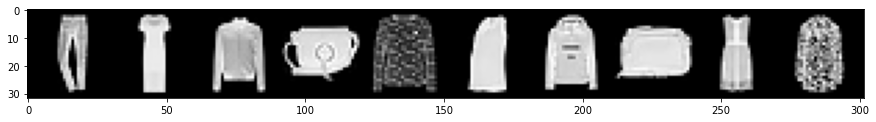

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))
plt.show()

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
device

'cuda:0'

## Model parameters

In [9]:
class VAE(nn.Module):
    def __init__(self, hidden_size):
        super(VAE, self).__init__()
        
        self.hidden_size = hidden_size
        self.encoder = nn.Sequential(nn.Linear(784,392),
                                     nn.ReLU())
        
        self.hidden_mu = nn.Linear(392, self.hidden_size)
        self.hidden_log_var = nn.Linear(392, self.hidden_size)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_size, 392),
                                     nn.ReLU(),
                                     nn.Linear(392, 784),
                                     nn.Sigmoid())
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std) # get normal distribution size of sigma
        return mu + z*std
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output 

hidden_dim = 64
net = VAE(hidden_dim)
optimizer = torch.optim.Adam(params = net.parameters())
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

## Training and testing

In [10]:
def loss_fn(mu, log_var, x_out, x):
    kl_loss = -0.5 * torch.sum( 1 + log_var - mu**2 - torch.exp(log_var))
    recon_loss = F.binary_cross_entropy(x_out, x.view(-1, 784), reduction='sum')
    loss = recon_loss + kl_loss
    return loss

num_epochs = 13
log_interval = 50
history = {'train':[], 'test':[]}

In [11]:
def train(epoch):
    net.train()
    running_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm_notebook(trainloader)):
        optimizer.zero_grad()
        mu, log_var, x_out = net(data)
        loss = loss_fn(mu, log_var, x_out, data)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        if batch_idx % (log_interval*6) == 0:
            history['train'].append(loss.item()/len(data))
    print("===> Epoch: {}/{} Average train loss: {:.4f}".format(epoch, num_epochs, running_loss/len(trainloader.dataset)))
    
def test(epoch):
    net.eval()
    running_loss = 0
    for batch_idx, (data, _) in enumerate(testloader):
        with torch.no_grad():
            mu, log_var, x_out = net(data)
            loss = loss_fn(mu, log_var, x_out, data)
            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                history['test'].append(loss.item()/len(data))
    print("===> Test set loss: {:.4f}".format(running_loss/len(testloader.dataset)))

if __name__ == "__main__":
    for epoch in range(1, num_epochs+1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, hidden_dim) # 'output' of the bottleneck
            sample = net.decode(sample)
            save_image(sample.view(64, 1, 28, 28), 'vae_results/sample_' + str(epoch) + '.png')

  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 1/13 Average train loss: 270.0779
===> Test set loss: 255.1553


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 2/13 Average train loss: 249.9143
===> Test set loss: 248.9674


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 3/13 Average train loss: 246.4005
===> Test set loss: 247.2390


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 4/13 Average train loss: 244.8430
===> Test set loss: 245.9753


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 5/13 Average train loss: 243.9291
===> Test set loss: 245.1837


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 6/13 Average train loss: 243.2939
===> Test set loss: 244.8861


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 7/13 Average train loss: 242.8684
===> Test set loss: 244.3242


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 8/13 Average train loss: 242.5396
===> Test set loss: 244.9222


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 9/13 Average train loss: 242.2415
===> Test set loss: 244.3419


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 10/13 Average train loss: 241.9784
===> Test set loss: 244.1559


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 11/13 Average train loss: 241.8515
===> Test set loss: 243.6953


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 12/13 Average train loss: 241.6637
===> Test set loss: 243.7191


  0%|          | 0/3000 [00:00<?, ?it/s]

===> Epoch: 13/13 Average train loss: 241.5100
===> Test set loss: 243.3467


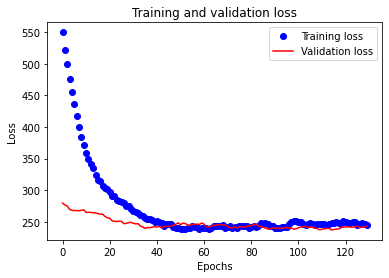

In [12]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.clf()
loss_values = smooth_curve(history['train'])
val_loss_values = smooth_curve(history['test'])
epochs = np.arange(len(val_loss_values))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

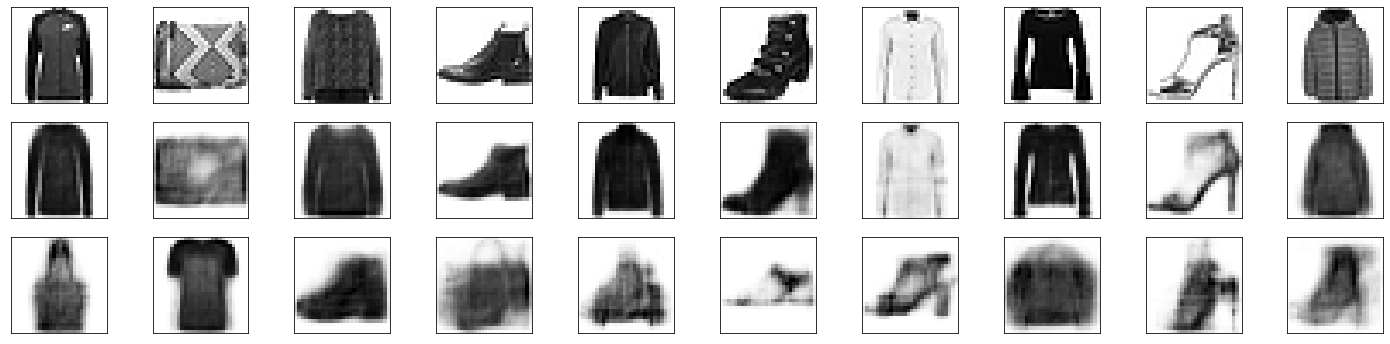

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
_, __, recon = net(images_flatten)
sample = torch.randn(10, hidden_dim)
gen = net.decode(sample)

images = 255 - images.numpy()[:10]
recon = 255 - recon.view(batch_size, 1, 28, 28).detach().numpy()[:10]
gen = 255 - gen.view(10, 1, 28, 28).detach().numpy()

fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,6))

for images, row in zip([images, recon, gen], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## MCMC

In [ ]:
class VAE_MCMC(nn.Module): # TODO: new architecture + HMC + no optimizer
    def __init__(self, hidden_size):
        super(VAE, self).__init__()
        
        self.hidden_size = hidden_size
        self.encoder = nn.Sequential(nn.Linear(784,392),
                                     nn.ReLU())
        
        self.hidden_mu = nn.Linear(392, self.hidden_size)
        self.hidden_log_var = nn.Linear(392, self.hidden_size)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_size, 392),
                                     nn.ReLU(),
                                     nn.Linear(392, 784),
                                     nn.Sigmoid())
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std) # get normal distribution size of sigma
        return mu + z*std
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output 


hidden_dim = 64
net = VAE_MCMC(hidden_dim)

In [ ]:
eps = torch.ones(hidden_dim) # initial step size as a vector for each parameter
# has to depend on t?

In [ ]:
def train(epoch): # iterations are outside the function
    net.train()
    L = int(torch.linalg.norm(eps).item()) # leapfrog steps for HMC
    
    for batch_idx, (data, _) in enumerate(tqdm_notebook(trainloader)):
        mu, log_var, x_out = net(data) # z???
        # TODO: compute gradients for decoder and encoder with loss_fn
        loss = loss_fn(mu, log_var, x_out, data)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        